In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from PIL import Image


In [82]:
#train_dataset = VOCSegmentation(root='data/', year='2012', image_set='train', download=True)

# writing custom dataset, inheriting from VOCSegmentation dataset
class VOCSegmentationWithPIL(VOCSegmentation):
    def __init__(self, root='data', year='2012', image_set='train',
                 download=True, image_size=(224, 224)):
        super().__init__(root=root, year=year, image_set=image_set, download=download)
        self.image_resize = T.Resize(image_size)
        self.mask_transform = T.Compose([
            T.Resize(image_size, interpolation=Image.NEAREST),
            T.PILToTensor(),  # Keeps label values intact
        ])

    def __getitem__(self, index):
        image, mask = super().__getitem__(index)
        image = self.image_resize(image)  # still PIL.Image
        mask = self.mask_transform(mask).squeeze(0).long()  # [H, W] as LongTensor
        return image, mask

In [45]:
def collate_fn_pil(batch):
    images, masks = zip(*batch)  # tuple of lists
    return list(images), torch.stack(masks)  # keep images as list of PIL


In [46]:
train_dataset = VOCSegmentationWithPIL(
    root='src/data_train',
    year='2012',
    image_set='train',
    download=True,
    image_size=(224, 224)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn_pil,
    pin_memory=True
)

Using downloaded and verified file: src/data_train/VOCtrainval_11-May-2012.tar
Extracting src/data_train/VOCtrainval_11-May-2012.tar to src/data_train


In [47]:
val_dataset = VOCSegmentationWithPIL(
    root='src/data_val',
    year='2012',
    image_set='val',
    download=True,
    image_size=(224, 224)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn_pil,
    pin_memory=True
)

Using downloaded and verified file: src/data_val/VOCtrainval_11-May-2012.tar
Extracting src/data_val/VOCtrainval_11-May-2012.tar to src/data_val


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class UNetDecoder(nn.Module):
    def __init__(self, in_channels=1024, num_classes=21):
        super().__init__()

        # Upsample from 16x16 -> 32x32 -> 64x64 -> 128x128 -> 224x224
        self.up1 = self._upsample_block(in_channels, 512)
        self.up2 = self._upsample_block(512, 256)
        self.up3 = self._upsample_block(256, 128)
        self.up4 = self._upsample_block(128, 64)

        # Skip connections
        self.skip_32 = nn.Conv2d(in_channels, 512, kernel_size=1)
        self.skip_64 = nn.Conv2d(512, 256, kernel_size=1)
        self.skip_128 = nn.Conv2d(256, 128, kernel_size=1)

        # Final prediction layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

        # Auxiliary outputs (for deeper supervision)
        self.aux1_conv = nn.Conv2d(128, num_classes, kernel_size=1)  # from x3
        self.aux2_conv = nn.Conv2d(64, num_classes, kernel_size=1)   # from x4    
    
    def _upsample_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2)  # just Added dropout to regularize because it was observed after 20 epoch it was overfitting
        )

    def forward(self, x):
        # x: [B, 1024, 16, 16]

        x1 = self.up1(x)  # 16 -> 32
        skip_32 = F.interpolate(self.skip_32(x), size=x1.shape[2:], mode='bilinear', align_corners=False)
        x1 = x1 + skip_32

        x2 = self.up2(x1)  # 32 -> 64
        skip_64 = F.interpolate(self.skip_64(x1), size=x2.shape[2:], mode='bilinear', align_corners=False)
        x2 = x2 + skip_64

        x3 = self.up3(x2)  # 64 -> 128
        skip_128 = F.interpolate(self.skip_128(x2), size=x3.shape[2:], mode='bilinear', align_corners=False)
        x3 = x3 + skip_128

        x4 = self.up4(x3)  # 128 -> 256

        # Main output
        x_out = F.interpolate(x4, size=(224, 224), mode='bilinear', align_corners=False)
        x_out = self.final_conv(x_out)

        # Auxiliary outputs
        aux1 = F.interpolate(self.aux1_conv(x3), size=(224, 224), mode='bilinear', align_corners=False)
        aux2 = F.interpolate(self.aux2_conv(x4), size=(224, 224), mode='bilinear', align_corners=False)

        return x_out, aux1, aux2

In [5]:
import torch
from transformers import AutoImageProcessor, Dinov2Model

In [6]:
class DinoSegModel(nn.Module):
    def __init__(self, freeze_dino=True, num_classes=21):
        super().__init__()
        self.dino = Dinov2Model.from_pretrained("facebook/dinov2-large")
        self.decoder = UNetDecoder(in_channels=1024, num_classes=num_classes)

        if freeze_dino:
            # Step 1: Freeze all DINO weights
            for param in self.dino.parameters():
                param.requires_grad = False

            # Step 2: Unfreeze last few transformer blocks for fine-tuning
            # for name, param in self.dino.named_parameters():
            #     if "blocks.23" in name or "blocks.22" in name:
            #         param.requires_grad = True
            
            # Unfreeze last 6 blocks 
            for name, param in self.dino.named_parameters():
                if any(f"blocks.{i}" in name for i in range(18, 24)):
                    param.requires_grad = True


    def forward(self, pixel_values):  # Input: [B, 3, 224, 224]
        feats = self.dino(pixel_values).last_hidden_state  # [B, 257, 1024]
        feats = feats[:, 1:, :]  # remove CLS token
        feats = feats.reshape(-1, 16, 16, 1024).permute(0, 3, 1, 2)  # [B, 1024, 16, 16]

        x_out, aux1, aux2 = self.decoder(feats)
        return x_out, aux1, aux2

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm  # progress bar

# Model Setup
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
model = DinoSegModel(freeze_dino=True).to(device)  # freeze_dino=False for fine-tuning

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

num_epochs = 100
train_losses = []
val_losses = []

model.train()

def evaluate(model, val_loader, criterion, image_processor, device, epoch):
    model.eval()
    val_loss = 0.0
    
    val_loop = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")

    with torch.no_grad():
        for step, (images, masks) in enumerate(val_loop):
            inputs = image_processor(images, return_tensors='pt').to(device)
            masks = masks.to(device)

            outputs, _, _ = model(inputs.pixel_values)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # if step == 0:
            #     # Show predictions on first batch
            #     preds = outputs.argmax(dim=1)
            #     plt.figure(figsize=(10, 4))
            #     plt.subplot(1, 3, 1)
            #     plt.imshow(images[0])
            #     plt.title("Input Image")
            #     plt.axis("off")

            #     plt.subplot(1, 3, 2)
            #     plt.imshow(masks[0].cpu(), cmap='tab20')
            #     plt.title("Ground Truth")
            #     plt.axis("off")

            #     plt.subplot(1, 3, 3)
            #     plt.imshow(preds[0].cpu(), cmap='tab20')
            #     plt.title(f"Prediction (Epoch {epoch+1})")
            #     plt.axis("off")
            #     plt.tight_layout()
            #     plt.show()

    # model.train()
    return val_loss / len(val_loader)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, masks in loop:
        inputs = image_processor(images, return_tensors='pt').to(device)
        masks = masks.to(device)

        outputs, _, _ = model(inputs.pixel_values)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    #avg_val_loss = evaluate(model, val_loader, criterion, image_processor, device, epoch)
    # Only evaluate every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_val_loss = evaluate(model, val_loader, criterion, image_processor, device, epoch)
        val_losses.append(avg_val_loss)

    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")
    
    if epoch >= 10:
        print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f}")


In [17]:
len(train_losses), len(val_losses)

(100, 10)

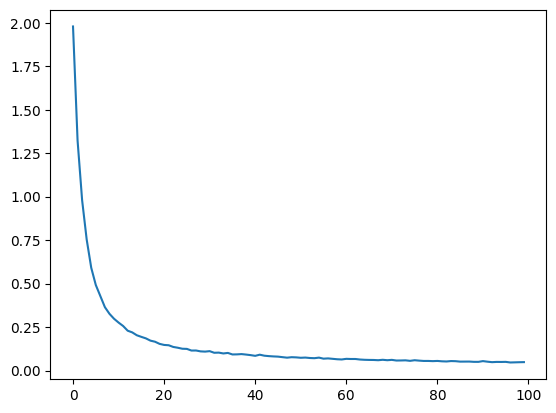

In [18]:
plt.plot(range(num_epochs), train_losses, label='Train Loss')

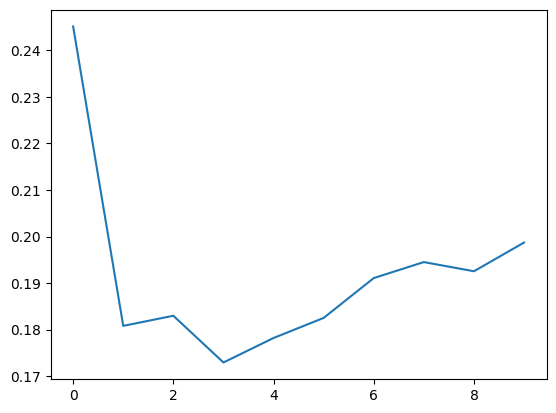

In [19]:
plt.plot(range(10), val_losses, label='Train Loss')

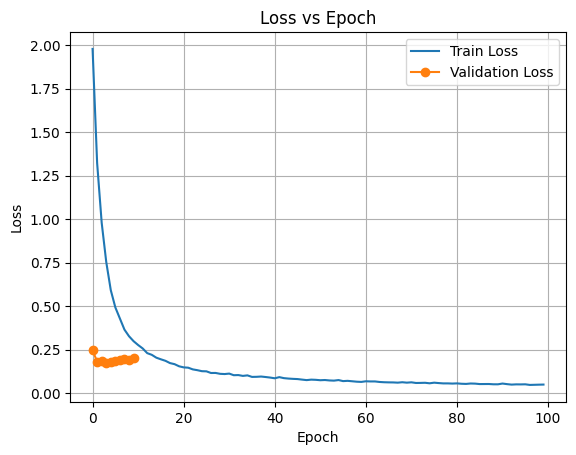

In [20]:
import matplotlib.pyplot as plt

plt.figure()

# Plot train loss (has value every epoch)
plt.plot(range(num_epochs), train_losses, label='Train Loss')

# Prepare filtered val loss and x-ticks
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_values = [v for v in val_losses if v is not None]

plt.plot(val_epochs, val_values, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
# plt.savefig('loss_plot.png')
# plt.close()


### With checkpoints

In [99]:
from src.lovasz_losses import lovasz_softmax
def hybrid_loss_fn(logits, target, ignore_index=255):
    ce = F.cross_entropy(logits, target, ignore_index=ignore_index)
    lv = lovasz_softmax(logits, target, ignore=ignore_index)
    return ce + lv

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassJaccardIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# ------------------ Setup ------------------
num_classes = 21
ignore_index = 255
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = DinoSegModel(freeze_dino=True).to(device)
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)

# from src.lovasz_losses import lovasz_softmax
# def lovasz_loss_fn(logits, targets):
#     return lovasz_softmax(logits, targets, ignore=255)
# criterion = lovasz_loss_fn

#criterion = hybrid_loss_fn

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Metric
miou_metric = MulticlassJaccardIndex(num_classes=num_classes, ignore_index=ignore_index).to(device)

# Training config
num_epochs = 50
train_losses, val_losses, val_ious = [], [], []

# Paths
best_model_path = "best_model.pth"
checkpoint_path = "last_checkpoint.pth"
best_val_loss = float('inf')
start_epoch = 0

# ------------------ Load from Checkpoint (if exists) ------------------
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resumed training from checkpoint at epoch {start_epoch}")

# ------------------ Validation ------------------
def evaluate(model, loader, criterion, image_processor, device, epoch):
    model.eval()
    val_loss = 0.0
    miou_metric.reset()
    save_dir = os.path.join("val_preds_kitto", f"epoch_{epoch+1}")
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        val_loop = tqdm(loader, desc=f"Validation Epoch {epoch+1}")
        for step, (images, masks) in enumerate(val_loop):
            #inputs = image_processor(images, return_tensors='pt').to(device)
            inputs = torch.stack([T.ToTensor()(img) for img in images]).to(device)
            inputs = T.Normalize(mean=[0.5]*3, std=[0.5]*3)(inputs)
            masks = masks.to(device)
            
            # outputs, _, _ = model(inputs.pixel_values)
            outputs, _, _ = model(inputs)
            loss = criterion(outputs, masks)
            
            #out, aux1, aux2 = model(inputs.pixel_values) # if using AutoImageProcessor of DINO
            # out, aux1, aux2 = model(inputs)
            # main_loss = criterion(out, masks)
            # aux_loss1 = criterion(aux1, F.interpolate(masks.unsqueeze(1).float(), size=aux1.shape[2:], mode='nearest').squeeze(1).long())
            # aux_loss2 = criterion(aux2, F.interpolate(masks.unsqueeze(1).float(), size=aux2.shape[2:], mode='nearest').squeeze(1).long())
            # loss = main_loss + 0.4 * aux_loss1 + 0.4 * aux_loss2
        
            val_loss += loss.item()
            val_loop.set_postfix(val_loss=loss.item())

            preds = outputs.argmax(dim=1)
            #preds = out.argmax(dim=1)
            miou_metric.update(preds, masks)

            # Save every sample in the batch
            for i in range(len(images)):
                image_np = images[i]
                mask_np = masks[i].cpu().numpy()
                pred_np = preds[i].cpu().numpy()

                #plt.imsave(os.path.join(save_dir, f"image_{step}_{i}.jpg"), image_np)
                plt.imsave(os.path.join(save_dir, f"gt_{step}_{i}.png"), mask_np, cmap='nipy_spectral')
                plt.imsave(os.path.join(save_dir, f"pred_{step}_{i}.png"), pred_np, cmap='nipy_spectral')

    return val_loss / len(loader), miou_metric.compute().item()

# ------------------ Training Loop ------------------
for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, masks in loop:
        #inputs = image_processor(images, return_tensors='pt').to(device)
        
        inputs = torch.stack([T.ToTensor()(img) for img in images]).to(device)
        inputs = T.Normalize(mean=[0.5]*3, std=[0.5]*3)(inputs)
        
        masks = masks.to(device)

        # outputs, _, _ = model(inputs.pixel_values)
        outputs, _, _ = model(inputs)
        loss = criterion(outputs, masks)
        
        #out, aux1, aux2 = model(inputs.pixel_values)
        # out, aux1, aux2 = model(inputs)
        # main_loss = criterion(out, masks)
        # aux_loss1 = criterion(aux1, F.interpolate(masks.unsqueeze(1).float(), size=aux1.shape[2:], mode='nearest').squeeze(1).long())
        # aux_loss2 = criterion(aux2, F.interpolate(masks.unsqueeze(1).float(), size=aux2.shape[2:], mode='nearest').squeeze(1).long())
        # loss = main_loss + 0.4 * aux_loss1 + 0.4 * aux_loss2
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate only every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_val_loss, val_miou = evaluate(model, val_loader, criterion, image_processor, device, epoch)
        scheduler.step(avg_val_loss)
        val_losses.append(avg_val_loss)
        val_ious.append(val_miou)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val mIoU: {val_miou:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model at epoch {epoch+1} with val loss {avg_val_loss:.4f}")
    else:
        val_losses.append(None)
        val_ious.append(None)

    # Save checkpoint every epoch
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")


Epoch 1/50: 100%|██████████| 183/183 [00:24<00:00,  7.39it/s, loss=2.94]


Checkpoint saved at epoch 1


Epoch 2/50: 100%|██████████| 183/183 [00:24<00:00,  7.39it/s, loss=1.87]


Checkpoint saved at epoch 2


Epoch 3/50: 100%|██████████| 183/183 [00:24<00:00,  7.38it/s, loss=1.29]


Checkpoint saved at epoch 3


Epoch 4/50: 100%|██████████| 183/183 [00:24<00:00,  7.33it/s, loss=1.03] 


Checkpoint saved at epoch 4


Epoch 5/50: 100%|██████████| 183/183 [00:24<00:00,  7.33it/s, loss=0.727]


Checkpoint saved at epoch 5


Epoch 6/50: 100%|██████████| 183/183 [00:25<00:00,  7.31it/s, loss=0.713]


Checkpoint saved at epoch 6


Epoch 7/50: 100%|██████████| 183/183 [00:25<00:00,  7.30it/s, loss=0.59] 


Checkpoint saved at epoch 7


Epoch 8/50: 100%|██████████| 183/183 [00:25<00:00,  7.29it/s, loss=0.46] 


Checkpoint saved at epoch 8


Epoch 9/50: 100%|██████████| 183/183 [00:25<00:00,  7.31it/s, loss=0.453]


Checkpoint saved at epoch 9


Validation Epoch 10: 100%|██████████| 182/182 [00:25<00:00,  7.14it/s, val_loss=1.29] 


Epoch 10 | Train Loss: 0.4374 | Val Loss: 0.3970 | Val mIoU: 0.7569
Saved best model at epoch 10 with val loss 0.3970
Checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████| 183/183 [00:25<00:00,  7.31it/s, loss=0.355]


Checkpoint saved at epoch 11


Epoch 12/50: 100%|██████████| 183/183 [00:25<00:00,  7.31it/s, loss=0.484]


Checkpoint saved at epoch 12


Epoch 13/50: 100%|██████████| 183/183 [00:25<00:00,  7.29it/s, loss=0.344]


Checkpoint saved at epoch 13


Epoch 14/50: 100%|██████████| 183/183 [00:25<00:00,  7.30it/s, loss=0.283]


Checkpoint saved at epoch 14


Epoch 15/50: 100%|██████████| 183/183 [00:25<00:00,  7.30it/s, loss=0.364]


Checkpoint saved at epoch 15


Epoch 16/50: 100%|██████████| 183/183 [00:25<00:00,  7.30it/s, loss=0.302]


Checkpoint saved at epoch 16


Epoch 17/50: 100%|██████████| 183/183 [00:25<00:00,  7.29it/s, loss=0.186]


Checkpoint saved at epoch 17


Epoch 18/50: 100%|██████████| 183/183 [00:25<00:00,  7.26it/s, loss=0.167]


Checkpoint saved at epoch 18


Epoch 19/50: 100%|██████████| 183/183 [00:25<00:00,  7.29it/s, loss=0.305]


Checkpoint saved at epoch 19


Validation Epoch 20: 100%|██████████| 182/182 [00:25<00:00,  7.08it/s, val_loss=0.343] 


Epoch 20 | Train Loss: 0.2232 | Val Loss: 0.2808 | Val mIoU: 0.7878
Saved best model at epoch 20 with val loss 0.2808
Checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████| 183/183 [00:25<00:00,  7.29it/s, loss=0.186]


Checkpoint saved at epoch 21


Epoch 22/50: 100%|██████████| 183/183 [00:25<00:00,  7.26it/s, loss=0.331]


Checkpoint saved at epoch 22


Epoch 23/50: 100%|██████████| 183/183 [00:25<00:00,  7.28it/s, loss=0.152]


Checkpoint saved at epoch 23


Epoch 24/50: 100%|██████████| 183/183 [00:25<00:00,  7.30it/s, loss=0.241]


Checkpoint saved at epoch 24


Epoch 25/50: 100%|██████████| 183/183 [00:25<00:00,  7.29it/s, loss=0.166] 


Checkpoint saved at epoch 25


Epoch 26/50: 100%|██████████| 183/183 [00:25<00:00,  7.29it/s, loss=0.126] 


Checkpoint saved at epoch 26


Epoch 27/50: 100%|██████████| 183/183 [00:25<00:00,  7.30it/s, loss=0.195] 


Checkpoint saved at epoch 27


Epoch 28/50: 100%|██████████| 183/183 [00:25<00:00,  7.29it/s, loss=0.132] 


Checkpoint saved at epoch 28


Epoch 29/50: 100%|██████████| 183/183 [00:25<00:00,  7.30it/s, loss=0.216] 


Checkpoint saved at epoch 29


Validation Epoch 30: 100%|██████████| 182/182 [00:25<00:00,  7.08it/s, val_loss=0.228] 


Epoch 30 | Train Loss: 0.1555 | Val Loss: 0.2674 | Val mIoU: 0.7931
Saved best model at epoch 30 with val loss 0.2674
Checkpoint saved at epoch 30


Epoch 31/50: 100%|██████████| 183/183 [00:25<00:00,  7.31it/s, loss=0.123] 


Checkpoint saved at epoch 31


Epoch 32/50: 100%|██████████| 183/183 [00:25<00:00,  7.29it/s, loss=0.137] 


Checkpoint saved at epoch 32


Epoch 33/50: 100%|██████████| 183/183 [00:25<00:00,  7.28it/s, loss=0.125] 


Checkpoint saved at epoch 33


Epoch 34/50: 100%|██████████| 183/183 [00:25<00:00,  7.30it/s, loss=0.134] 


Checkpoint saved at epoch 34


Epoch 35/50: 100%|██████████| 183/183 [00:25<00:00,  7.28it/s, loss=0.327] 


Checkpoint saved at epoch 35


Epoch 36/50: 100%|██████████| 183/183 [00:25<00:00,  7.28it/s, loss=0.195] 


Checkpoint saved at epoch 36


Epoch 37/50: 100%|██████████| 183/183 [00:25<00:00,  7.26it/s, loss=0.146] 


Checkpoint saved at epoch 37


Epoch 38/50: 100%|██████████| 183/183 [00:25<00:00,  7.27it/s, loss=0.0946]


Checkpoint saved at epoch 38


Epoch 39/50: 100%|██████████| 183/183 [00:25<00:00,  7.28it/s, loss=0.179] 


Checkpoint saved at epoch 39


Validation Epoch 40: 100%|██████████| 182/182 [00:25<00:00,  7.07it/s, val_loss=0.281] 


Epoch 40 | Train Loss: 0.1239 | Val Loss: 0.2745 | Val mIoU: 0.7929
Checkpoint saved at epoch 40


Epoch 41/50: 100%|██████████| 183/183 [00:25<00:00,  7.27it/s, loss=0.0852]


Checkpoint saved at epoch 41


Epoch 42/50: 100%|██████████| 183/183 [00:25<00:00,  7.29it/s, loss=0.139] 


Checkpoint saved at epoch 42


Epoch 43/50: 100%|██████████| 183/183 [00:25<00:00,  7.29it/s, loss=0.149] 


Checkpoint saved at epoch 43


Epoch 44/50: 100%|██████████| 183/183 [00:25<00:00,  7.28it/s, loss=0.0788]


Checkpoint saved at epoch 44


Epoch 45/50: 100%|██████████| 183/183 [00:25<00:00,  7.27it/s, loss=0.0999]


Checkpoint saved at epoch 45


Epoch 46/50: 100%|██████████| 183/183 [00:25<00:00,  7.30it/s, loss=0.0983]


Checkpoint saved at epoch 46


Epoch 47/50: 100%|██████████| 183/183 [00:25<00:00,  7.30it/s, loss=0.115] 


Checkpoint saved at epoch 47


Epoch 48/50: 100%|██████████| 183/183 [00:25<00:00,  7.31it/s, loss=0.0858]


Checkpoint saved at epoch 48


Epoch 49/50: 100%|██████████| 183/183 [00:25<00:00,  7.31it/s, loss=0.0943]


Checkpoint saved at epoch 49


Validation Epoch 50: 100%|██████████| 182/182 [00:25<00:00,  7.07it/s, val_loss=0.229] 


Epoch 50 | Train Loss: 0.1106 | Val Loss: 0.2759 | Val mIoU: 0.7931
Checkpoint saved at epoch 50


In [9]:
from torch.utils.data import Dataset
from PIL import Image
import os

class KITTISegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(224, 224)):
        self.image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png') or fname.endswith('.jpg')])
        self.mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')])

        self.image_transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
        
        self.mask_transform = T.Compose([
            T.Resize(image_size, interpolation=Image.NEAREST),
            T.PILToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx])  # Assumes masks are already in correct class format
        return self.image_transform(image), self.mask_transform(mask).squeeze(0).long()


In [10]:
kitti_dataset = KITTISegmentationDataset(
    image_dir='kitti_data/training/image_2',
    mask_dir='kitti_data/training/semantic',
    image_size=(224, 224)
)


kitti_loader = DataLoader(
    kitti_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)



In [11]:
model = DinoSegModel(freeze_dino=True, num_classes=21).to(device)
model.load_state_dict(torch.load("/home/iiitb/Desktop/anant/playground/ProjectBytes/best_model1.pth", map_location=device))
model.eval()


DinoSegModel(
  (dino): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-23): 24 x Dinov2Layer(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
 

In [12]:
count = 0
for images, masks in kitti_loader:
        print(images.shape, masks.shape)
        print("Unique labels in masks:", torch.unique(masks))
        count += 1 
        # if count ==100:
        #         break
        
print(count)

torch.Size([8, 3, 224, 224]) torch.Size([8, 224, 224])
Unique labels in masks: tensor([ 0,  4,  7,  8,  9, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 31, 32, 33])
torch.Size([8, 3, 224, 224]) torch.Size([8, 224, 224])
Unique labels in masks: tensor([ 0,  4,  6,  7,  8, 11, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        33])
torch.Size([8, 3, 224, 224]) torch.Size([8, 224, 224])
Unique labels in masks: tensor([ 4,  7,  8, 10, 11, 12, 13, 15, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28])
torch.Size([8, 3, 224, 224]) torch.Size([8, 224, 224])
Unique labels in masks: tensor([ 0,  4,  6,  7,  8, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 28, 31, 32, 33])
torch.Size([8, 3, 224, 224]) torch.Size([8, 224, 224])
Unique labels in masks: tensor([ 0,  4,  6,  7,  8, 10, 11, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 33])
torch.Size([8, 3, 224, 224]) torch.Size([8, 224, 224])
Unique labels in masks: tensor([ 4,  7,  8, 10, 11, 15, 17, 1

In [ ]:
from torchmetrics.classification import MulticlassJaccardIndex

NUM_CLASSES = 34   # 0 to 33 possible
IGNORE_INDEX = 255

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize mIoU metric
# miou_metric = MulticlassJaccardIndex(
#     num_classes=NUM_CLASSES,
#     ignore_index=IGNORE_INDEX,
# ).to(device)

miou_metric = MulticlassJaccardIndex(num_classes=34, ignore_index=255).to(device)

def evaluate_kitti(model, loader, device):
    model.eval()
    miou_metric.reset()

    with torch.no_grad():
        val_loop = tqdm(loader, desc="Evaluating mIoU")

        for step, (images, masks) in enumerate(val_loop):
            images = images.to(device)
            masks = masks.to(device)

            images = T.Normalize(mean=[0.5]*3, std=[0.5]*3)(images)

            outputs, _, _ = model(images) 
            preds = outputs.argmax(dim=1)

            miou_metric.update(preds, masks)

    mean_iou = miou_metric.compute().item()
    print(f"\nMean IoU over validation set: {mean_iou:.4f}")
    return mean_iou

val_miou = evaluate_kitti(model, kitti_loader, device)
print(f"KITTI mIoU: {val_miou:.4f}")


Evaluating mIoU:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating mIoU: 100%|██████████| 25/25 [00:02<00:00,  9.14it/s]


Mean IoU over validation set: 0.0005
KITTI mIoU: 0.0005


In [108]:
val_losses

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.397011216033946,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.2807839595927642,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.2674014389842421,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.2745082508158553,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.2758915059800659]

In [109]:
val_ious

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.756900429725647,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.7877744436264038,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.7931466102600098,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.7928969860076904,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.7931216955184937]

In [110]:
train_losses

[3.3017658900693467,
 2.2418576622269843,
 1.6404918927312548,
 1.2029355542907298,
 0.9187097155331262,
 0.7507291931272204,
 0.6450010179821911,
 0.5576519427078018,
 0.4910727442939425,
 0.43741350201635415,
 0.40406178931395215,
 0.36425441983944734,
 0.3360209233773862,
 0.30995759880933604,
 0.295253973271026,
 0.27690230774097757,
 0.2614204498425208,
 0.23872487548270513,
 0.23015329107397892,
 0.22324426378545864,
 0.20956332647735304,
 0.19900025459912304,
 0.2014072966135916,
 0.18480507516470113,
 0.18441755927162742,
 0.17157224187108336,
 0.1653711997338983,
 0.1639689958649255,
 0.16502071611705374,
 0.1555203477867314,
 0.14783788211847262,
 0.14627523622551902,
 0.1471713434884457,
 0.14565281985235995,
 0.13718269191315915,
 0.13754930548736308,
 0.13395286787077376,
 0.13105200931348435,
 0.1320030850058045,
 0.12385824229059324,
 0.12981282905395566,
 0.12496666976662933,
 0.1197212013960536,
 0.11579769705244101,
 0.11760692909115651,
 0.11526916858032753,
 0.11726

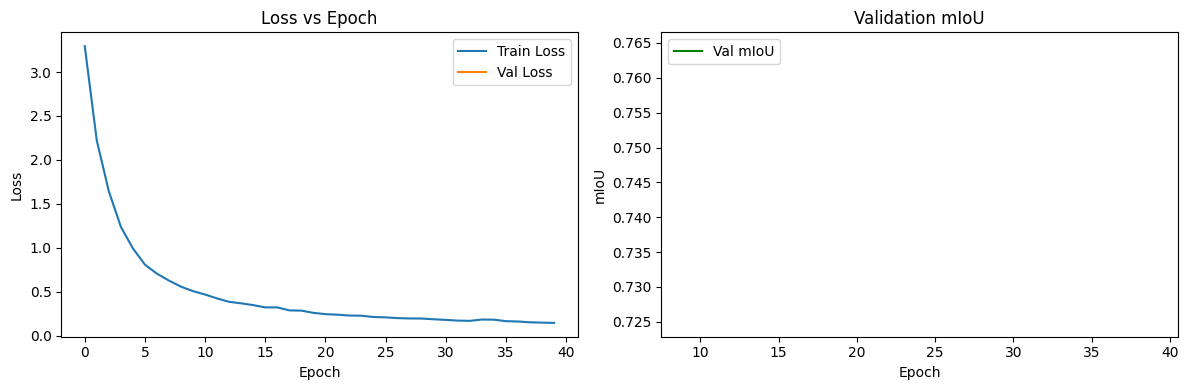

In [80]:
# Plot Loss and mIoU
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_ious, label="Val mIoU", color="green")
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.title("Validation mIoU")
plt.legend()

plt.tight_layout()
plt.show()

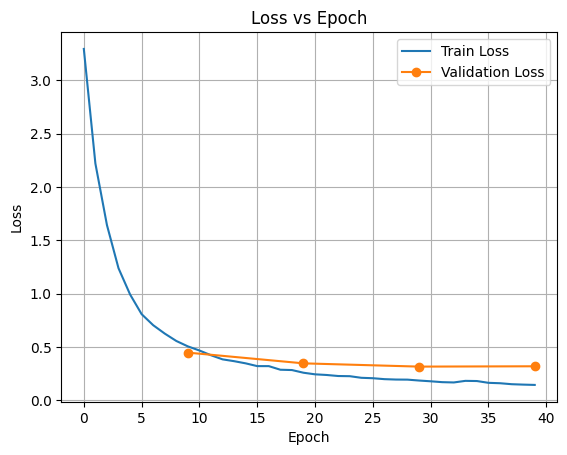

In [81]:
import matplotlib.pyplot as plt

plt.figure()

# Plot train loss (has value every epoch)
plt.plot(range(num_epochs), train_losses, label='Train Loss')

# Prepare filtered val loss and x-ticks
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_values = [v for v in val_losses if v is not None]

plt.plot(val_epochs, val_values, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
# plt.savefig('loss_plot.png')
# plt.close()


In [ ]:
# for inferencing
# model.load_state_dict(torch.load("best_model.pth"))
# model.eval()

### Inference

In [33]:
import PIL

In [ ]:

#model = DinoSegModel().to(device)
#model.load_state_dict(torch.load("checkpoints/best_model.pth"))
# model.eval()

# image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
# img = Image.open("/home/iiitb/Desktop/anant/playground/ProjectBytes/src/pred_airplane1.png").convert("RGB")
# inputs = image_processor(img, return_tensors="pt").to(device)

# with torch.no_grad():
#     output = model(inputs.pixel_values)
#     pred = output.argmax(1).squeeze().cpu().numpy()

# plt.imshow(pred, cmap='gray')
# plt.title("Prediction")
# plt.show()


: 